<a href="https://colab.research.google.com/github/otoperalias/miscellanea/blob/main/Wikidata_queries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracción de datos de Wikidata

Link a un post interesante al respecto, donde se proporcionan las clases y funciones que defino a continuación
https://itnext.io/extracting-data-from-wikidata-using-sparql-and-python-59e0037996f


### Instalamos librería requerida, importamos librerías y definimos clases y funciones

In [1]:
!pip install SPARQLWrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.3 MB/s eta 0:00:00


In [2]:
import sys
import pandas as pd
from typing import List, Dict
from SPARQLWrapper import SPARQLWrapper, JSON

class WikiDataQueryResults:
    """
    A class that can be used to query data from Wikidata using SPARQL and return the results as a Pandas DataFrame or a list
    of values for a specific key.
    """
    def __init__(self, query: str):
        """
        Initializes the WikiDataQueryResults object with a SPARQL query string.
        :param query: A SPARQL query string.
        """
        self.user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
        self.endpoint_url = "https://query.wikidata.org/sparql"
        self.sparql = SPARQLWrapper(self.endpoint_url, agent=self.user_agent)
        self.sparql.setQuery(query)
        self.sparql.setReturnFormat(JSON)

    def __transform2dicts(self, results: List[Dict]) -> List[Dict]:
        """
        Helper function to transform SPARQL query results into a list of dictionaries.
        :param results: A list of query results returned by SPARQLWrapper.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        new_results = []
        for result in results:
            new_result = {}
            for key in result:
                new_result[key] = result[key]['value']
            new_results.append(new_result)
        return new_results

    def _load(self) -> List[Dict]:
        """
        Helper function that loads the data from Wikidata using the SPARQLWrapper library, and transforms the results into
        a list of dictionaries.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        results = self.sparql.queryAndConvert()['results']['bindings']
        results = self.__transform2dicts(results)
        return results

    def load_as_dataframe(self) -> pd.DataFrame:
        """
        Executes the SPARQL query and returns the results as a Pandas DataFrame.
        :return: A Pandas DataFrame representing the query results.
        """
        results = self._load()
        return pd.DataFrame.from_dict(results)

### Example query
Query that retrieves the name, location, and founding date of all cities in the United States

In [ ]:
query = """
SELECT ?city ?cityLabel ?location ?locationLabel ?founding_date
WHERE {
  ?city wdt:P31/wdt:P279* wd:Q515.
  ?city wdt:P17 wd:Q30.
  ?city wdt:P625 ?location.
  ?city wdt:P571 ?founding_date.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

In [ ]:
data_extracter = WikiDataQueryResults(query)
df = data_extracter.load_as_dataframe()
df

                                    city         founding_date  \
0     http://www.wikidata.org/entity/Q62  1776-06-29T00:00:00Z   
1  http://www.wikidata.org/entity/Q16554  1858-11-22T00:00:00Z   
2  http://www.wikidata.org/entity/Q16568  1791-01-01T00:00:00Z   
3  http://www.wikidata.org/entity/Q23197  1779-01-01T00:00:00Z   
4  http://www.wikidata.org/entity/Q25330  1719-01-01T00:00:00Z   

                             location      cityLabel  \
0       Point(-122.416388888 37.7775)  San Francisco   
1  Point(-104.984722222 39.739166666)         Denver   
2          Point(-81.65 30.316666666)   Jacksonville   
3   Point(-86.774444444 36.162222222)      Nashville   
4   Point(-74.765833333 40.220277777)        Trenton   

                        locationLabel  
0       Point(-122.416388888 37.7775)  
1  Point(-104.984722222 39.739166666)  
2          Point(-81.65 30.316666666)  
3   Point(-86.774444444 36.162222222)  
4   Point(-74.765833333 40.220277777)  


### Query to retrieve people born in Andalusia, their place of birth, date of birth and occupation.

Use https://query.wikidata.org/ to develop the query

In [3]:
query="""
SELECT ?item ?itemLabel ?occupationLabel ?place ?placeLabel ?coord ?birthyear
WHERE {
    ?item wdt:P31 wd:Q5.
    ?item wdt:P19/wdt:P131* wd:Q5783.
    ?item wdt:P106 ?occupation.
    ?item wdt:P569 ?birthyear.
    ?item wdt:P19 ?place.
    ?place wdt:P625 ?coord.
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],es". }
}
"""

In [ ]:
data_extracter = WikiDataQueryResults(query)
df = data_extracter.load_as_dataframe()
df

In [6]:
df.columns

Index(['item', 'place', 'birthyear', 'coord', 'itemLabel', 'occupationLabel',
       'placeLabel'],
      dtype='object')

In [ ]:
df.occupationLabel.value_counts()[:50]

In [29]:
df[df.occupationLabel.str.contains("pol")==True].occupationLabel.value_counts()

político                 1924
politólogo                 12
activista político          7
policía                     4
polista                     2
político municipal          2
asesor político             1
comisario de policía        1
polígrafo                   1
comentarista político       1
filósofo político           1
waterpolista                1
Name: occupationLabel, dtype: int64

#### 1. Nos quedamos con los politicos

In [81]:
pol=df.loc[df.occupationLabel=="político"]

#### 2. Duplicados

In [82]:
pol.item.duplicated().any()

True

Vemos que hay duplicados, que en teoría no debería haberlos. Eso es porque para algunas entradas hay varias fechas de nacimiento o varios lugares de nacimiento. Por tanto, hay que limpiar los datos.

In [83]:
# 1. Eliminar los placeLabel que contengan "provincia". Estas observaciones tan imprecisas no son útiles
pol=pol.loc[pol.placeLabel.str.contains("provincia")==False]

In [84]:
# 2. Eliminar los placeLabel que contengan "Andalucía".
pol=pol.loc[pol.placeLabel.str.contains("Andalucía")==False]

In [85]:
# 3. Nos quedamos con uno, el que resulte de aplicar la función
pol=pol.groupby(by="item", as_index=False).first()

#### 3. Procesamos la fecha de nacimiento

In [86]:
pol['dob']=pol.birthyear.str[:4]

In [87]:
pol=pol.loc[pol.dob!="http"] # Registros sin fecha de nacimiento

In [88]:
pol['dob']=pol.dob.astype(int)

<ipython-input-88-7dd7915d049d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pol['dob']=pol.dob.astype(int)


<Axes: >

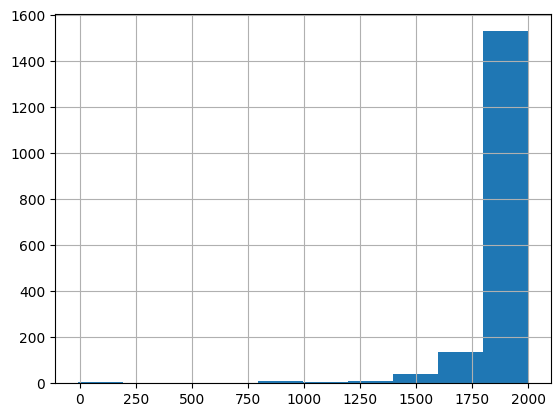

In [89]:
pol.dob.hist()

#### 4. Procesamos lugar de nacimiento

In [90]:
import geopandas as gpd
from shapely.geometry import Point

In [118]:
# Extraemos las coordenadas
pol['pos_inicio_paren']=pol.coord.str.find("(")
pol['pos_espacio']=pol.coord.str.find(" ")

pol['lon'] = pol.apply(lambda x: x['coord'][x['pos_inicio_paren']+1:x['pos_espacio']], 1)
pol['lat'] = pol.apply(lambda x: x['coord'][x['pos_espacio']+1:-1], 1)

pol=pol.loc[pol.coord.str.contains("http")==False]

In [120]:
# Columna con la geometría
pol['geometry'] = gpd.points_from_xy(pol.lon, pol.lat, crs="EPSG:4326")


<ipython-input-120-76362e566a54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pol['geometry'] = gpd.points_from_xy(pol.lon, pol.lat, crs="EPSG:4326")


In [121]:
gdf=gpd.GeoDataFrame(pol,geometry=pol.geometry,crs="EPSG:4326")

#### 5. Importamos capa municipios y asignamos códigos

In [123]:
m=gpd.read_file('municipio_proj.shp')
m=m[m.CODIGOINE!="22028/22106"]
m['mun_code']=m.CODIGOINE.astype("int64")
m=m[m.mun_code<53000]
m=m[['mun_code', 'geometry']]

In [124]:
gdf=gdf.to_crs(m.crs)

In [125]:
final=gpd.sjoin(gdf,m,)

In [133]:
final

,item,place,birthyear,coord,itemLabel,occupationLabel,placeLabel,dob,pos_inicio_paren,pos_espacio,lon,lat,geometry,index_right,mun_code
0,http://www.wikidata.org/entity/Q100152810,http://www.wikidata.org/entity/Q49562,1847-01-01T00:00:00Z,Point(-3.016666666 36.75),Rafael Sierra Valenzuela,político,Adra,1847,5,18,-3.016666666,36.75,POINT (3154834.594 1619239.041),282,4003
8,http://www.wikidata.org/entity/Q100754251,http://www.wikidata.org/entity/Q49562,1824-01-01T00:00:00Z,Point(-3.016666666 36.75),Fernando Roda González,político,Adra,1824,5,18,-3.016666666,36.75,POINT (3154834.594 1619239.041),282,4003
15,http://www.wikidata.org/entity/Q100755031,http://www.wikidata.org/entity/Q49562,1829-01-01T00:00:00Z,Point(-3.016666666 36.75),Juan Lirola Gómez,político,Adra,1829,5,18,-3.016666666,36.75,POINT (3154834.594 1619239.041),282,4003
18,http://www.wikidata.org/entity/Q100755269,http://www.wikidata.org/entity/Q49562,1798-01-01T00:00:00Z,Point(-3.016666666 36.75),Miguel Chacón y Durán,político,Adra,1798,5,18,-3.016666666,36.75,POINT (3154834.594 1619239.041),282,4003
380,http://www.wikidata.org/entity/Q19984008,http://www.wikidata.org/entity/Q49562,1934-07-22T00:00:00Z,Point(-3.016666666 36.75),Nicolás Linares Navarro,político,Adra,1934,5,18,-3.016666666,36.75,POINT (3154834.594 1619239.041),282,4003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,http://www.wikidata.org/entity/Q93125628,http://www.wikidata.org/entity/Q842658,1873-02-05T00:00:00Z,Point(-2.1239207 37.0981986),Juan Piqueras y Vázquez,político,Sorbas,1873,5,16,-2.1239207,37.0981986,POINT (3239416.334 1644132.525),361,4086
1725,http://www.wikidata.org/entity/Q95143924,http://www.wikidata.org/entity/Q1448408,1944-01-01T00:00:00Z,Point(-4.4987079 37.9399109),Manuel Armenteros Molina,político,El Carpio,1944,5,16,-4.4987079,37.9399109,POINT (3045820.048 1772505.329),2064,14018
1731,http://www.wikidata.org/entity/Q964443,http://www.wikidata.org/entity/Q611298,1782-03-17T00:00:00Z,Point(-3.555 36.910277777),Juan José Bonel y Orbe,político,El Pinar,1782,5,12,-3.555,36.910277777,POINT (3109918.921 1645047.576),2838,18910
1739,http://www.wikidata.org/entity/Q981646,http://www.wikidata.org/entity/Q932362,1957-12-15T00:00:00Z,Point(-2.894722222 38.320833333),Valeriano Gómez,político,Arroyo del Ojanco,1957,5,18,-2.894722222,38.320833333,POINT (3191645.333 1788757.505),3594,23905


In [137]:
columns=['itemLabel', 'dob','placeLabel','occupationLabel','mun_code']
final[columns].to_csv("and_politicians.csv")